## Where deep learning comes to place

Policy gradients have several appealing properties, for one they produce stochastic policies (by learning a probability distribution over actions given observations) whereas 

value based approaches are deterministic as they will typically choose actions greedily with respect to the value function being learned which can lead to under-exploration (one needs to introduce exploration strategies such as 
𝜖
ϵ-greedy explicitly to get around this).

<img src="QDL.png" alt="image" width="300"> <img src="Improved-QDL-arch.png" alt="image" width="300">


we want to have a *supervised learning model* that takes state and action and outputs the values of these pair
by calculates are the values for all actions, we can then choose the best action for this state
 but how will the model train ? using training set from the bellman equation

* agent will take different actions according the q_value or random action (according to epsilon) (replay buffer)
* we will calculate bellman equation
* we will use this q-value as our training set to calculate q_new (replay method)
* repeat

### policy based gradient method

each action has a value separatly 

In [10]:
import numpy as np
import gym

class PolicyNetwork:
    def __init__(self, input_dim, output_dim, learning_rate):
        self.weights = np.random.rand(input_dim, output_dim)
        self.learning_rate = learning_rate
    
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x))
        return exp_values / np.sum(exp_values)
    
    def forward(self, state):
        return self.softmax(np.dot(state, self.weights))
    
    def update(self, gradients):
        self.weights += self.learning_rate * gradients

def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards)
    cumulative_rewards = 0
    for t in reversed(range(len(rewards))):
        cumulative_rewards = rewards[t] + cumulative_rewards * gamma
        discounted_rewards[t] = cumulative_rewards
    return discounted_rewards

def normalize_rewards(rewards):
    mean = np.mean(rewards)
    std = np.std(rewards)
    return (rewards - mean) / (std + 1e-6)

def train_policy_network(env, policy_net, num_episodes, gamma):
    for episode in range(num_episodes):
        state = env.reset()
        episode_states, episode_actions, episode_rewards = [], [], []
        total_reward = 0
        done = False
        while not done:
            # Forward pass
            action_probs = policy_net.forward(state)
            action = np.random.choice(len(action_probs), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Store the state, action, and reward
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            total_reward += reward
            
            state = next_state
        
        # Compute discounted rewards and normalize
        discounted_rewards = discount_rewards(episode_rewards, gamma)
        normalized_rewards = normalize_rewards(discounted_rewards)
        
        # Compute gradients
        gradients = np.zeros_like(policy_net.weights)
        # For each move in this episode
        for t in range(len(episode_states)):
            state = episode_states[t]
            action = episode_actions[t]
            # gradient = state × weights × normalized_reward
            gradient = -np.outer(state, np.eye(policy_net.weights.shape[1])[action]) * normalized_rewards[t]
            gradients += gradient
        
        # Update the policy network
        policy_net.update(gradients)
        
        # Print episode statistics
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

# Example usage
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
learning_rate = 0.01
gamma = 0.99
num_episodes = 100

policy_net = PolicyNetwork(input_dim, output_dim, learning_rate)
train_policy_network(env, policy_net, num_episodes, gamma)


Episode 1/100, Total Reward: 56.0
Episode 2/100, Total Reward: 42.0
Episode 3/100, Total Reward: 33.0
Episode 4/100, Total Reward: 16.0
Episode 5/100, Total Reward: 23.0
Episode 6/100, Total Reward: 16.0
Episode 7/100, Total Reward: 15.0
Episode 8/100, Total Reward: 19.0
Episode 9/100, Total Reward: 13.0
Episode 10/100, Total Reward: 15.0
Episode 11/100, Total Reward: 25.0
Episode 12/100, Total Reward: 10.0
Episode 13/100, Total Reward: 29.0
Episode 14/100, Total Reward: 21.0
Episode 15/100, Total Reward: 17.0
Episode 16/100, Total Reward: 21.0
Episode 17/100, Total Reward: 11.0
Episode 18/100, Total Reward: 12.0
Episode 19/100, Total Reward: 14.0
Episode 20/100, Total Reward: 23.0
Episode 21/100, Total Reward: 21.0
Episode 22/100, Total Reward: 30.0
Episode 23/100, Total Reward: 28.0
Episode 24/100, Total Reward: 23.0
Episode 25/100, Total Reward: 12.0
Episode 26/100, Total Reward: 20.0
Episode 27/100, Total Reward: 13.0
Episode 28/100, Total Reward: 15.0
Episode 29/100, Total Reward:

###  value based gradient method

each state has a value function  

In [14]:
import numpy as np
import gym

class QLearningAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.1, discount_factor=0.99, epsilon=0.1):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((state_dim, action_dim))
    
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)  # Exploration: randomly select action
        else:
            return np.argmax(self.q_table[state])  # Exploitation: choose action with highest Q-value
    
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error

def train_q_learning(env, agent, num_episodes):
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state

# Create environment
env = gym.make('FrozenLake-v1')
state_dim = env.observation_space.n
action_dim = env.action_space.n

# Create Q-learning agent
agent = QLearningAgent(state_dim, action_dim)

# Train the agent
num_episodes = 1000
train_q_learning(env, agent, num_episodes)

# Test the trained agent
total_rewards = 0
num_test_episodes = 100
for _ in range(num_test_episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        total_rewards += reward
        state = next_state

average_reward = total_rewards / num_test_episodes
print("Average reward:", average_reward)


Average reward: 0.0


## Simple flow-chart


<img src="QDL.png" alt="image" width="300"> <img src="Improved-QDL-arch.png" alt="image" width="300">


we want to have a *supervised learning model* that takes state and action and outputs the values of these pair
by calculates are the values for all actions, we can then choose the best action for this state
 but how will the model train ? using training set from the bellman equation

* agent will take different actions according the q_value or random action (according to epsilon) (replay buffer)
* we will calculate bellman equation
* we will use this q-value as our training set to calculate q_new (replay method)
* repeat

## Calculating the target q_value

does the batch_size = one episode ?
does the target q_value reset each episode ?


In [ ]:
#assuming we already have the replay buffer, here is how to calculate the target q_value using the bellman equation
#creating the dataset for the model to train on
class QLearningAgent:
    def __init__(self, num_states, num_actions, gamma=0.99):
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        # Initialize Q-values as a dictionary with zeros
        self.Q_values = {state: [0] * num_actions for state in range(num_states)}

    def update_q_value(self, state, action, reward, next_state):
        max_next_q_value = max(self.Q_values[next_state])
        self.Q_values[state][action] = reward + self.gamma * max_next_q_value

    def display_q_values(self):
        print("Q-values:")
        for state, q_values in self.Q_values.items():
            print(f"State {state}: {q_values}")

# Define the environment parameters
num_states = 3
num_actions = 2

# Initialize the Q-learning agent
agent = QLearningAgent(num_states, num_actions)

# Define a list of experiences (state, action, reward, next_state)
#this is the "replay buffer"
#as if this is 1 episode
experiences = [
    (0, 0, 1, 1),  # Experience 1
    (1, 1, 2, 0),  # Experience 2
    (2, 0, 3, 1),  # Experience 3
    (1, 0, 4, 2),  # Experience 4
    (0, 1, 5, 2),  # Experience 5 (episode termination)
]

# Update Q-values for each experience
for i , experience in enumerate(experiences):
    state, action, reward, next_state = experience
    print(f"step number {i}, {agent.Q_values} ")
    agent.update_q_value(state, action, reward, next_state)

# Display Q-values after all experiences
agent.display_q_values()


Storing Experiences

## Trying building game with only bellman equation

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

EPSILON = 0.9

class GridWorldEnvironment:
    def __init__(self):
        self.env = gym.make('FrozenLake-v1',render_mode="rgb_array")
        self.num_states = self.env.observation_space.n
        self.state_size = self.env.observation_space.n
        self.num_actions = self.env.action_space.n
        print(f"Game contains {self.num_states} states and {self.num_actions} actions")
        self.Q_table = np.zeros((self.num_states, self.num_actions))
        print(f"shape of the qtest {self.Q_table.shape}")
        self.epsilon = EPSILON

    def train(self, num_episodes, discount_factor):
        random_ctr = 0
        non_random_ctr = 0
        for episode in range(num_episodes):
            state = self.env.reset()[0]
            done = False
            while not done:
                if np.max(self.Q_table[state]) == 0:
                    random_ctr +=1
                    action = self.env.action_space.sample()  # Explore
                else:
                    non_random_ctr +=1
                    action = np.argmax(self.Q_table[state])  # Exploit

                next_state, reward, done, _ , _ = self.env.step(action)
                self.Q_table[state][action] += 0.000001 * \
                (reward + discount_factor * np.max(self.Q_table[next_state]))
                state = next_state

        print(f"{random_ctr} random picks vs {non_random_ctr} non random picks")

    def test(self, max_steps=100):
        state = self.env.reset()[0]
        total_reward = 0
        for _ in range(max_steps):
            action = np.argmax(self.Q_table[state])
            # print(f"action taken {action}")
            state, reward, done, _ , _ = self.env.step(action)
            total_reward += reward
            self.env.render()
            plt.imshow(self.env.render())
            display.display(plt.gcf())    
            display.clear_output(wait=True)  
            if done:
                break
        return total_reward


In [ ]:
# Hyperparameters
NUM_EPISODES = 10000000
# LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.2

# Create environment
env = GridWorldEnvironment()

# Train the agent
env.train(num_episodes = NUM_EPISODES, discount_factor = DISCOUNT_FACTOR)    # Hyperparameters

print(env.Q_table)

In [ ]:
# Test the agent
total_reward = env.test()
print("Total reward:", total_reward)

## Building Game with DQN

In [90]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from collections import deque, namedtuple
import random


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

EPSILON = 0.9
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.9             # discount factor
ALPHA = 0.0001              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets = rewards + (gamma * max_qsa)
    q_values = q_network(states)
    indices = tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1)
    invalid_indices = tf.reduce_any(tf.reduce_any(indices < 0) | tf.reduce_any(indices >= q_values.shape, axis=1))
    if invalid_indices:
        print("Invalid indices detected!")
    q_values = tf.gather_nd(q_values, indices)

    loss = MSE(y_targets, q_values)    
    return loss

def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

class GridWorldEnvironment:
    def __init__(self):
        self.env = gym.make('FrozenLake-v1',render_mode="rgb_array")
        self.num_states = self.env.observation_space.n
        self.state_size = self.env.observation_space.n
        self.num_actions = self.env.action_space.n
        self.memory_buffer = []
        print(f"Game contains {self.num_states} states and {self.num_actions} actions")
        self.Q_table = np.zeros((self.num_states, self.num_actions))
        print(f"shape of the qtest {self.Q_table.shape}")
        self.epsilon = EPSILON
        # Define neural network model
        # env.q_network = load_model('gridworldmodel')
        self.q_network = Sequential([
        Input(shape=(1,)),                      
        Dense(units=64, activation='relu'),            
        Dense(units=64, activation='relu'),            
        Dense(units=self.num_actions, activation='linear'),
        ])

        self.target_q_network = Sequential([
        Input(shape=(1,)),                      
        Dense(units=64, activation='relu'),            
        Dense(units=64, activation='relu'),            
        Dense(units=self.num_actions, activation='linear'),
        ])

        self.optimizer = Adam(learning_rate=ALPHA)
    
    def agent_learn(self, experiences, gamma = GAMMA):
        # Calculate the loss
        with tf.GradientTape() as tape:
            loss = compute_loss(experiences, gamma, self.q_network, self.target_q_network)

        # Get the gradients of the loss with respect to the weights.
        gradients = tape.gradient(loss, self.q_network.trainable_variables)
        
        # Update the weights of the q_network.
        self.optimizer.apply_gradients(zip(gradients, self.q_network.trainable_variables))

        # update the weights of target q_network
        update_target_network(self.q_network, self.target_q_network)
    
    def evaluate(self, num_episodes=100, max_steps=100):
        total_rewards = []
        for _ in range(num_episodes):
            state = self.env.reset()[0]
            total_reward = 0
            for _ in range(max_steps):
                state_qn = np.expand_dims(state, axis=0)
                q_values = self.q_network(state_qn)
                action = np.argmax(q_values.numpy()[0])
                state, reward, done, _ , _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)
        avg_reward = np.mean(total_rewards)
        return avg_reward
    
    def train(self, num_episodes):
        total_point_history = []
        solved = False
        for i in range(num_episodes):
            if solved:
                break
            total_points = 0
            state = self.env.reset()[0]
            done = False
            for t in range(1000):
                state_np = np.array([state])
                state_qn = np.expand_dims(state_np, axis=0)  # state needs to be the right shape for the q_network
                #INPUT FOR THE NETWORK
                q_values = self.q_network(state_qn)
                # print("actions: ",np.argmax(q_values.numpy()[0]))

                if np.random.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()  # Explore
                    # print(f"q values are {q_values.numpy()[0]}")
                else:
                    # action = np.argmax(q_values[0][state])  # Exploit
                    action = np.argmax(q_values.numpy()[0])

                next_state, reward, done, _ , _ = self.env.step(action)
                self.memory_buffer.append(experience(state, action, reward, next_state, done))
                state = next_state
                # if len(memory_buffer) > 64:
                #     experiences = random.sample(memory_buffer, k=20)
                #     # print(f" state type {type(experiences[0].state)}. actions type {type(experiences[0].action)}\
                #     # reward {type(experiences[0].reward)}, next_states {type(experiences[0].next_state)}, done {type(experiences[0].done)}")
                #     states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]))
                #     actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]))
                #     rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]),dtype=tf.float32)
                #     next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]))
                #     done_vals = tf.convert_to_tensor(np.array([float(e.done) for e in experiences if e is not None]))
                #     self.agent_learn((states, actions, rewards, next_states, done_vals))
                    # print(len(states), len(actions), len(rewards), len(next_states), len(done_vals))
                # total_points += reward
                if reward == 1:
                    if self.epsilon > 0.1:
                        self.epsilon -= 0.001   
                    experiences = self.memory_buffer
                    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]))
                    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]))
                    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]),dtype=tf.float32)
                    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]))
                    done_vals = tf.convert_to_tensor(np.array([float(e.done) for e in experiences if e is not None]))
                    self.agent_learn((states, actions, rewards, next_states, done_vals))
                    # print(f"\n\nEnvironment solved in {i+1} episodes!")
                    self.memory_buffer = []
                    # solved = True
                    break        
                if done:
                    experiences = self.memory_buffer
                    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]))
                    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]))
                    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]),dtype=tf.float32)
                    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]))
                    done_vals = tf.convert_to_tensor(np.array([float(e.done) for e in experiences if e is not None]))
                    self.agent_learn((states, actions, rewards, next_states, done_vals))
                    self.memory_buffer = []
                    break
                
            # total_point_history.append(total_points)
            # av_latest_points = np.mean(total_point_history[-100:])
            if (i+1) % 1000 == 0:
                print(f" evaluation for {i + 1} is {self.evaluate()}")
                # print(f"\rEpisode {i+1} | Total point average of the last 100 episodes: {av_latest_points:.2f}")

                    
    def test(self, max_steps=100):
        state = self.env.reset()[0]
        total_reward = 0
        for _ in range(max_steps):
            state_qn = np.expand_dims(state, axis=0)
            q_values = self.q_network(state_qn)
            action = np.argmax(q_values.numpy()[0])
            state, reward, done, _ , _ = self.env.step(action)
            total_reward += reward
            self.env.render()
            plt.imshow(self.env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)  
            if done:
                break
        return total_reward

# Hyperparameters
NUM_EPISODES = 20000

# Create environment
env = GridWorldEnvironment()

# Train the agent
env.train(num_episodes = NUM_EPISODES)    # Hyperparameters

# print(env.q_network)

# total_reward = env.test()
# print("Total reward:", total_reward)
env.q_network.save('gridworldmodel')

Game contains 16 states and 4 actions
shape of the qtest (16, 4)
 evaluation for 1000 is 0.06
 evaluation for 2000 is 0.02
 evaluation for 3000 is 0.06
 evaluation for 4000 is 0.03
 evaluation for 5000 is 0.03
 evaluation for 6000 is 0.04
 evaluation for 7000 is 0.03
 evaluation for 8000 is 0.06
 evaluation for 9000 is 0.06
 evaluation for 10000 is 0.0
 evaluation for 11000 is 0.02
 evaluation for 12000 is 0.0
 evaluation for 13000 is 0.06
 evaluation for 14000 is 0.02
 evaluation for 15000 is 0.03
 evaluation for 16000 is 0.0
 evaluation for 17000 is 0.03
 evaluation for 18000 is 0.04
 evaluation for 19000 is 0.03
 evaluation for 20000 is 0.0


INFO:tensorflow:Assets written to: gridworldmodel/assets


INFO:tensorflow:Assets written to: gridworldmodel/assets


Total reward: 0.0


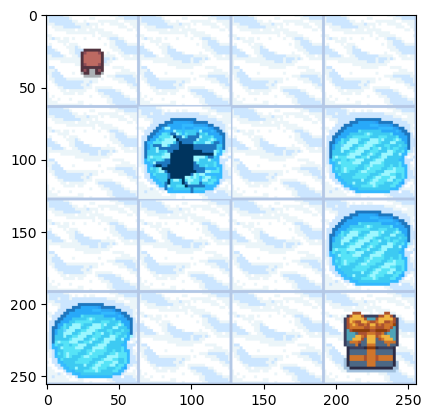

In [95]:
total_reward = env.test()
print("Total reward:", total_reward)